# I. Setup

## i. Imports

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## ii. GPU

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2380067182870815059
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18191768066105015777
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [7]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

# II. Data Preprocessing

## i. Define dataset path and classes

In [17]:
DATA_DIR = Path("BiNet_Dataset")
CLASSES = ["Corrosionstain", "Cracks", "Exposedbars", "Spalling"]

## ii. Remove corrupted files

In [20]:
'''
def remove_corrupted_files(data_dir, classes):
    for class_name in classes:
        class_dir = data_dir / class_name
        for img_file in class_dir.iterdir():
            try:
                img = Image.open(img_file)
                img.verify()  # Verify integrity
            except (IOError, SyntaxError):
                print(f"Removing corrupted file: {img_file}")
                os.remove(img_file)

remove_corrupted_files(DATA_DIR, CLASSES)
'''

'\ndef remove_corrupted_files(data_dir, classes):\n    for class_name in classes:\n        class_dir = data_dir / class_name\n        for img_file in class_dir.iterdir():\n            try:\n                img = Image.open(img_file)\n                img.verify()  # Verify integrity\n            except (IOError, SyntaxError):\n                print(f"Removing corrupted file: {img_file}")\n                os.remove(img_file)\n\nremove_corrupted_files(DATA_DIR, CLASSES)\n'

## iii. Check class distribution

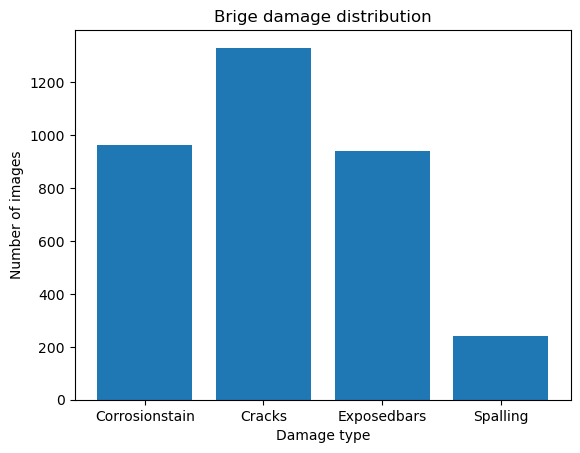

dict_values([961, 1330, 940, 240])

In [23]:
class_counts = {class_name: len(list((DATA_DIR / class_name).glob("*.png"))) for class_name in CLASSES}
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Brige damage distribution")
plt.xlabel("Damage type")
plt.ylabel("Number of images")
plt.show()
class_counts.values()

Class imbalance is present. It will be addressed using weights.

## iv. Split dataset

### a. Function to split dataset into training(70%), valuation(10%), and testing sets(20%).

In [28]:
def split_data(data_dir, classes, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    train_dir = data_dir / "train"
    val_dir = data_dir / "val"
    test_dir = data_dir / "test"

    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    for class_name in classes:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir)

split_data(DATA_DIR, CLASSES)            

### b. Declare directory variables 

In [30]:
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

### c. Declare class variables for the data sets

In [32]:
def get_class_dir(dir):
    class1_dir = dir / "Corrosionstain"
    class2_dir = dir / "Cracks"
    class3_dir = dir / "Exposedbars"
    class4_dir = dir / "Spalling"
    return class1_dir, class2_dir, class3_dir, class4_dir

TRAIN_CORROSIONSTAIN_DIR, TRAIN_CRACKS_DIR, TRAIN_EXPOSEDBARS_DIR, TRAIN_SPALLING_DIR  = get_class_dir(TRAIN_DIR)
VAL_CORROSIONSTAIN_DIR, VAL_CRACKS_DIR, VAL_EXPOSEDBARS_DIR, VAL_SPALLING_DIR  = get_class_dir(VAL_DIR)
TEST_CORROSIONSTAIN_DIR, TEST_CRACKS_DIR, TEST_EXPOSEDBARS_DIR, TEST_SPALLING_DIR  = get_class_dir(TEST_DIR)

### d. Check the number of images in the sets  

In [34]:
def dir_len(dir):
    return len(os.listdir(dir))

print("Training Set:")
print("   Corrosionstain: " + str(dir_len(TRAIN_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TRAIN_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TRAIN_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TRAIN_SPALLING_DIR)) + " images")

print("\nValuation Set:")
print("   Corrosionstain: " + str(dir_len(VAL_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(VAL_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(VAL_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(VAL_SPALLING_DIR)) + " images")

print("\nTesting Set:")
print("   Corrosionstain: " + str(dir_len(TEST_CORROSIONSTAIN_DIR)) + " images")
print("   Cracks: " + str(dir_len(TEST_CRACKS_DIR)) + " images")
print("   Exposedbars: " + str(dir_len(TEST_EXPOSEDBARS_DIR)) + " images")
print("   Spalling: " + str(dir_len(TEST_SPALLING_DIR)) + " images")

Training Set:
   Corrosionstain: 870 images
   Cracks: 1209 images
   Exposedbars: 855 images
   Spalling: 216 images

Valuation Set:
   Corrosionstain: 183 images
   Cracks: 257 images
   Exposedbars: 175 images
   Spalling: 44 images

Testing Set:
   Corrosionstain: 345 images
   Cracks: 470 images
   Exposedbars: 343 images
   Spalling: 90 images


## ii. Create Generators

### a. Data augmentation for training data

In [41]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### b. Rescale for validation and test data

In [44]:
val_test_gen = ImageDataGenerator(rescale=1.0/255)

### c. Load data using generators

In [47]:
IMG_WIDTH = IMG_HEIGHT = 224
BATCH_SIZE = 64

train_generator = data_gen.flow_from_directory(
    DATA_DIR / "train",
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_gen.flow_from_directory(
    DATA_DIR / "val",
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_gen.flow_from_directory(
    DATA_DIR / "test",
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3150 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Found 1248 images belonging to 4 classes.


### d. Address class imbalance using weights

In [49]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.9051724137931034, 1: 0.6513647642679901, 2: 0.9210526315789473, 3: 3.6458333333333335}


## ii. Data visualization

### a. Show sample images from training set

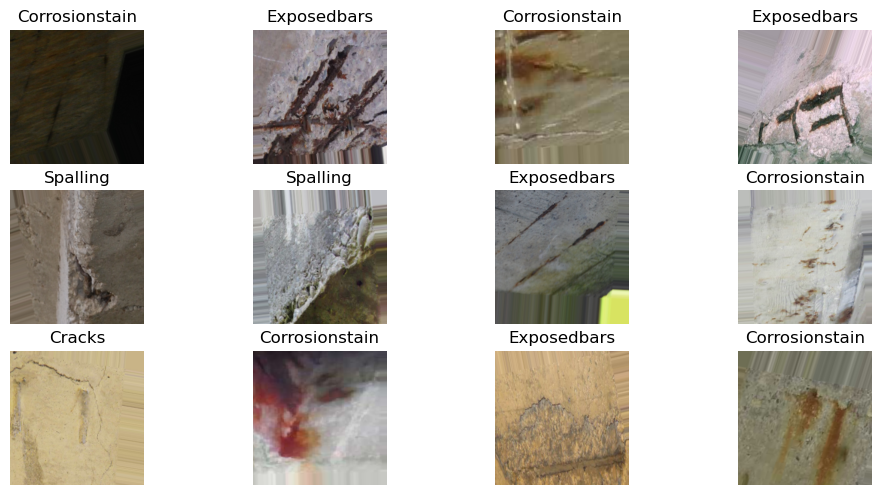

In [54]:
def plot_sample_images(generator, class_labels):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_labels)

# III. Convolutional Neural Networks: 14 Model Trials

### i. Function for model accuracy and loss plot

In [68]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

## i. Trial 1: model_uno

### a. Model creation

In [58]:
model_uno = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)), # Image Size: 150 x 150
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),

    Dense(128, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model_uno.compile(
    optimizer= Adam (learning_rate=0.001),
    loss= 'binary_crossentropy',
    metrics = ['accuracy']
)

### b. Model summary

In [62]:
model_uno.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 50,468,356
Trainable params: 50,468,356
Non-trainable params: 0
____________________________________________

### c. Model fitting

In [65]:
model_uno_history = model_uno.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
50/50 [==============================] - 73s 1s/step - loss: 1.7216 - accuracy: 0.2867 - val_loss: 0.5739 - val_accuracy: 0.3460
Epoch 2/10
50/50 [==============================] - 51s 1s/step - loss: 0.5084 - accuracy: 0.4765 - val_loss: 0.4854 - val_accuracy: 0.5979
Epoch 3/10
50/50 [==============================] - 48s 958ms/step - loss: 0.4866 - accuracy: 0.5517 - val_loss: 0.4534 - val_accuracy: 0.5857
Epoch 4/10
50/50 [==============================] - 48s 952ms/step - loss: 0.4804 - accuracy: 0.5159 - val_loss: 0.4817 - val_accuracy: 0.5508
Epoch 5/10
50/50 [==============================] - 48s 956ms/step - loss: 0.4577 - accuracy: 0.5889 - val_loss: 0.4333 - val_accuracy: 0.6571
Epoch 6/10
50/50 [==============================] - 49s 984ms/step - loss: 0.4506 - accuracy: 0.5940 - val_loss: 0.4170 - val_accuracy: 0.6100
Epoch 7/10
50/50 [==============================] - 50s 1000ms/step - loss: 0.4512 - accuracy: 0.6054 - val_loss: 0.4287 - val_accuracy: 0.5781
Epoc

### d. Model history 

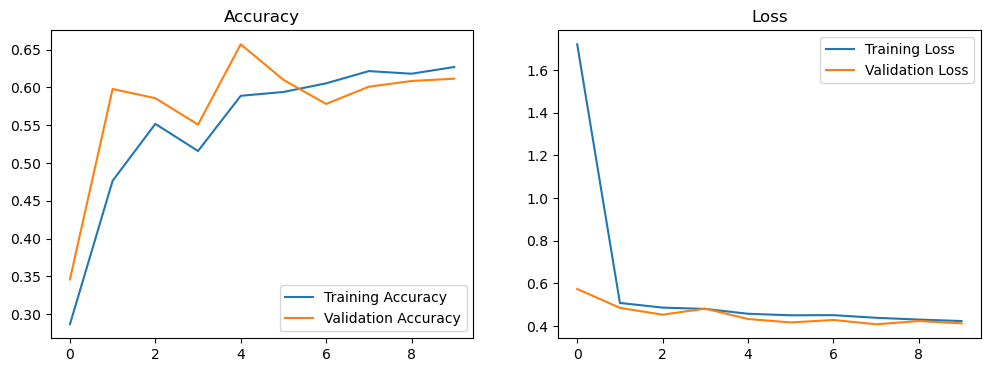

In [71]:
plot_training_history(model_uno_history)